# Entrega 2: Procesamiento y Análisis de Datos
## Fundamentos del Procesamiento de Lenguaje Natural

---

## Índice
1. Preprocesamiento de Datos
2. Representaciones Tradicionales (BoW y TF-IDF)
3. Embeddings No Contextuales (Word2Vec, FastText, GloVe)
4. Embeddings Contextuales (BERT, Sentence-BERT)
5. Estructura de Datos procesados
6. Resultados y Conclusiones

In [1]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

---
## 1. Preprocesamiento de Datos

### 1.1 Estadísticas del Dataset

In [2]:
# Cargar datos procesados
df_processed = pd.read_pickle('../data/processed/processed_documents.pkl')

with open('../data/processed/statistics.json', 'r') as f:
    stats = json.load(f)

print("Estadisticas del dataset procesado:\n")
print(f"Total de documentos: {stats['total_documents']}")
print(f"Total de tokens: {stats['total_tokens']:,}")
print(f"Total de oraciones: {stats['total_sentences']:,}")
print(f"Vocabulario (tokens únicos): {stats['unique_tokens']:,}")
print(f"Longitud promedio por documento: {stats['avg_doc_length']:.2f} tokens")

Estadisticas del dataset procesado:

Total de documentos: 46
Total de tokens: 1,091,421
Total de oraciones: 114,333
Vocabulario (tokens únicos): 43,763
Longitud promedio por documento: 23726.54 tokens


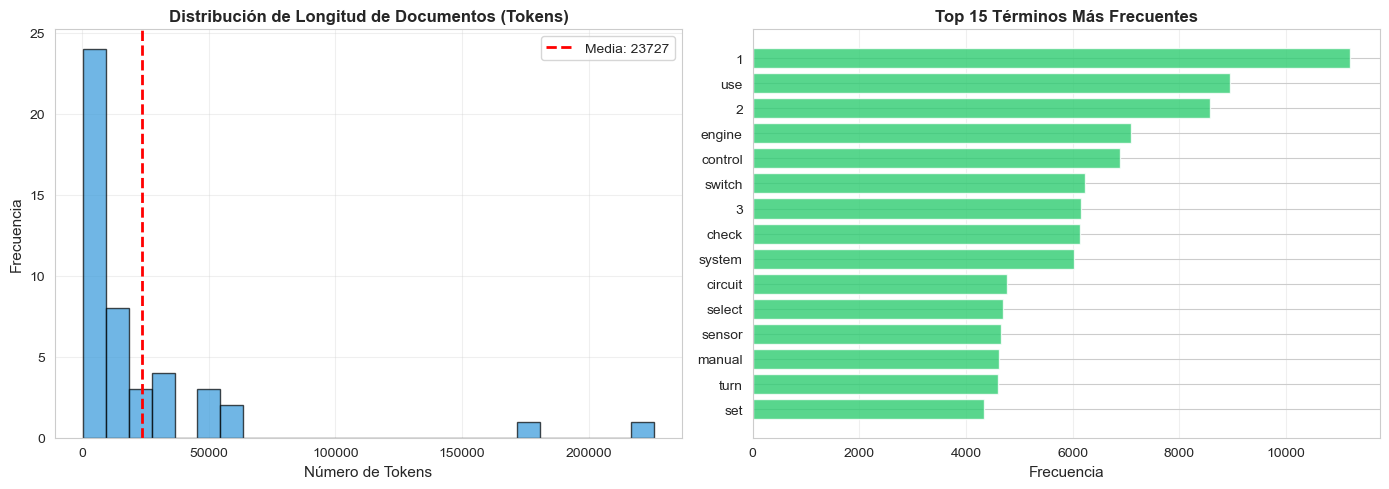


Total de lemas únicos en el corpus: 47,821


In [3]:
# Visualización de distribución de documentos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de tokens
axes[0].hist(df_processed['num_tokens'], bins=25, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].axvline(df_processed['num_tokens'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {df_processed["num_tokens"].mean():.0f}')
axes[0].set_xlabel('Número de Tokens', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].set_title('Distribución de Longitud de Documentos (Tokens)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Top términos más frecuentes
all_lemmas = []
for lemmas in df_processed['lemmas']:
    all_lemmas.extend(lemmas)
lemma_freq = Counter(all_lemmas)
top_terms = lemma_freq.most_common(15)

terms, freqs = zip(*top_terms)
axes[1].barh(range(len(terms)), freqs, color='#2ecc71', alpha=0.8)
axes[1].set_yticks(range(len(terms)))
axes[1].set_yticklabels(terms)
axes[1].set_xlabel('Frecuencia', fontsize=11)
axes[1].set_title('Top 15 Términos Más Frecuentes', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal de lemas únicos en el corpus: {len(lemma_freq):,}")

---
## 2. Representaciones Tradicionales

### 2.1 Bag of Words (BoW)

Representación basada en frecuencia de términos sin considerar el orden.

In [4]:
# Cargar BoW
bow_matrix = np.load('../data/visualizations/bow_matrix.npy')

with open('../data/vocabularies/vocabularies.json', 'r') as f:
    vocabs = json.load(f)
    bow_vocab = vocabs['bow_vocab']

print("Bag of Words:\n")
print(f"Dimensiones: {bow_matrix.shape[0]} documentos × {bow_matrix.shape[1]} términos")
print(f"Tamaño del vocabulario: {len(bow_vocab):,}")
print(f"Densidad: {(np.count_nonzero(bow_matrix) / bow_matrix.size * 100):.2f}%")
print(f"Dispersión (sparsity): {(100 - np.count_nonzero(bow_matrix) / bow_matrix.size * 100):.2f}%")

# Top términos por frecuencia
term_frequencies = bow_matrix.sum(axis=0)
bow_terms_df = pd.DataFrame({
    'termino': list(bow_vocab.keys()),
    'frecuencia': [term_frequencies[idx] for idx in bow_vocab.values()]
}).sort_values('frecuencia', ascending=False)

print(f"\n🔝 Top 10 términos:")
for i, row in bow_terms_df.head(10).iterrows():
    print(f"   {row['termino']}: {row['frecuencia']:.0f}")


Bag of Words:

Dimensiones: 46 documentos × 1000 términos
Tamaño del vocabulario: 1,000
Densidad: 43.54%
Dispersión (sparsity): 56.46%

🔝 Top 10 términos:
   engine: 7087
   circuit: 4779
   sensor: 4651
   air: 4143
   q: 3985
   de: 3620
   valve: 3310
   pressure: 3294
   image: 3292
   connector: 3222


### 2.2 TF-IDF

Representación que pondera los términos por su importancia relativa en el corpus.

In [5]:
# Cargar TF-IDF
tfidf_matrix = np.load('../data/visualizations/tfidf_matrix.npy')
tfidf_vocab = vocabs['tfidf_vocab']

print("TF-IDF")
print(f"Dimensiones: {tfidf_matrix.shape[0]} documentos × {tfidf_matrix.shape[1]} términos")
print(f"Rango de valores: [{tfidf_matrix.min():.4f}, {tfidf_matrix.max():.4f}]")
print(f"Media: {tfidf_matrix.mean():.4f} | Desv. Est.: {tfidf_matrix.std():.4f}")

# Top términos por TF-IDF
tfidf_scores = tfidf_matrix.sum(axis=0)
tfidf_terms_df = pd.DataFrame({
    'termino': list(tfidf_vocab.keys()),
    'tfidf_score': [tfidf_scores[idx] for idx in tfidf_vocab.values()]
}).sort_values('tfidf_score', ascending=False)

print(f"\nTop 10 términos por TF-IDF:")
for i, row in tfidf_terms_df.head(10).iterrows():
    print(f"   {row['termino']}: {row['tfidf_score']:.3f}")

TF-IDF
Dimensiones: 46 documentos × 1000 términos
Rango de valores: [0.0000, 0.7613]
Media: 0.0078 | Desv. Est.: 0.0306

Top 10 términos por TF-IDF:
   de: 3.614
   engine: 2.769
   image: 2.140
   battery: 2.119
   la: 1.893
   camera: 1.853
   call: 1.645
   e: 1.584
   click: 1.501
   download: 1.485


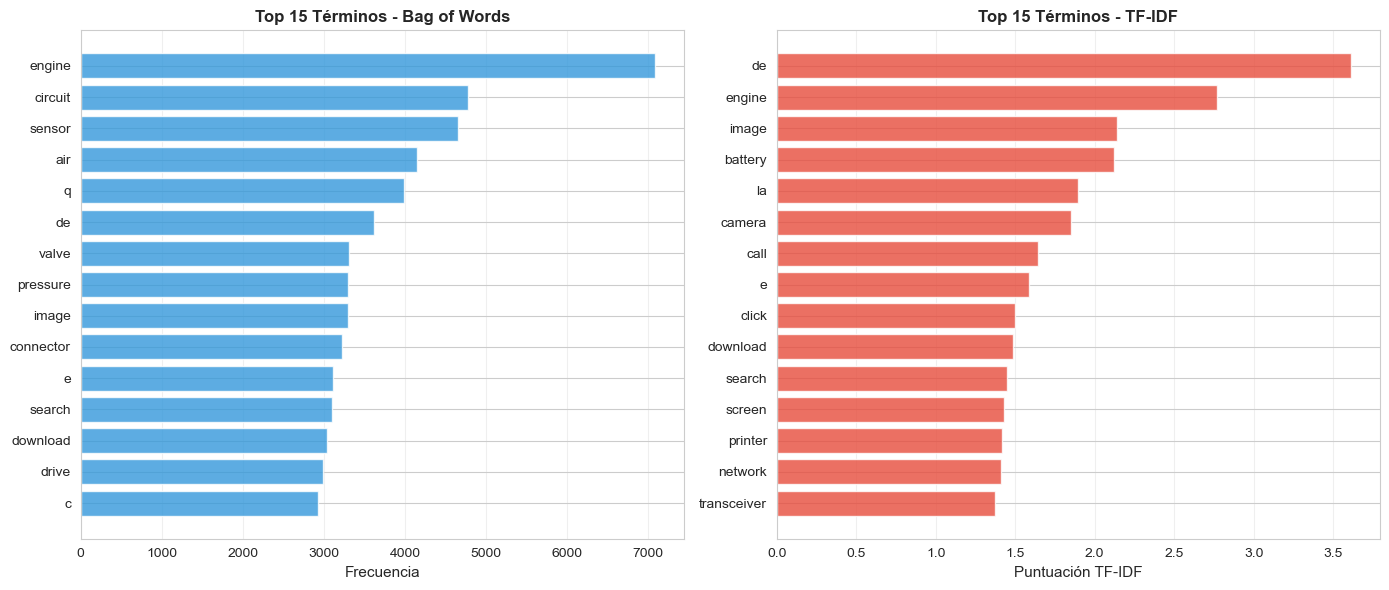

In [6]:
# Comparación visual BoW vs TF-IDF
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

top_n = 15

# BoW
bow_top = bow_terms_df.head(top_n)
axes[0].barh(range(top_n), bow_top['frecuencia'], color='#3498db', alpha=0.8)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(bow_top['termino'], fontsize=10)
axes[0].set_xlabel('Frecuencia', fontsize=11)
axes[0].set_title('Top 15 Términos - Bag of Words', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# TF-IDF
tfidf_top = tfidf_terms_df.head(top_n)
axes[1].barh(range(top_n), tfidf_top['tfidf_score'], color='#e74c3c', alpha=0.8)
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(tfidf_top['termino'], fontsize=10)
axes[1].set_xlabel('Puntuación TF-IDF', fontsize=11)
axes[1].set_title('Top 15 Términos - TF-IDF', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 3. Embeddings No Contextuales

### 3.1 Análisis Out-of-Vocabulary (OOV)

Comparación de la cobertura de vocabulario entre diferentes modelos de embeddings.

In [7]:
# Cargar análisis OOV
with open('../models/oov_analysis.json', 'r') as f:
    oov_analysis = json.load(f)

print("Análisis Out of Vocabulary (OOV)\n")

# Crear tabla comparativa
oov_data = []
for model_name, stats in oov_analysis.items():
    oov_data.append({
        'Modelo': model_name.upper(),
        'Total Palabras': stats['total_words'],
        'En Vocab': stats['in_vocab'],
        'OOV': stats['oov_count'],
        'OOV %': f"{stats['oov_percentage']:.2f}%"
    })

oov_df = pd.DataFrame(oov_data)
print(oov_df.to_string(index=False))

Análisis Out of Vocabulary (OOV)

  Modelo  Total Palabras  En Vocab   OOV  OOV %
WORD2VEC           47821     21040 26781 56.00%
FASTTEXT           47821     47821     0  0.00%
   GLOVE           47821     15769 32052 67.02%


Observaciones:
   * FastText maneja mejor palabras OOV gracias a n-gramas de caracteres
   * GloVe pre-entrenado tiene mejor cobertura inicial
   * Word2Vec custom se limita al vocabulario del corpus

### 3.2 Modelo Word2Vec Entrenado

Se ha entrenado un modelo Word2Vec custom con los siguientes parámetros:
- **Vector size:** 100 dimensiones
- **Window:** 5 palabras de contexto
- **Min count:** 2 apariciones mínimas
- **Epochs:** 10 iteraciones


In [8]:
# Cargar modelos para demostración
from gensim.models import Word2Vec, FastText

w2v_model = Word2Vec.load('../models/word2vec.model')
ft_model = FastText.load('../models/fasttext.model')

print("Ejemplos de similitud semantica:\n")

# Palabras de prueba
test_words = ['system', 'data', 'network']

for word in test_words:
    print(f"\nPalabras más similares a '{word}':")
    
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=5)
        for sim_word, score in similar:
            print(f"   {sim_word}: {score:.3f}")
    else:
        print(f"'{word}' no está en el vocabulario de Word2Vec")

Ejemplos de similitud semantica:


Palabras más similares a 'system':
   engineengine: 0.673
   systemgeneral: 0.669
   systemprecautionsprecaution: 0.667
   troubleshootingstepactionyesno1was: 0.657
   locationelectronic: 0.655

Palabras más similares a 'data':
   datum: 0.779
   datapoint: 0.653
   0024: 0.639
   devicemanual: 0.636
   0195: 0.635

Palabras más similares a 'network':
   lan: 0.784
   wired: 0.717
   wireless: 0.708
   smartphone: 0.702
   wl: 0.698


---
## 4. Embeddings Contextuales

### 4.1 BERT y Sentence-BERT

Se han utilizado modelos transformer pre-entrenados para generar embeddings contextuales:

- **BERT:** `bert-base-uncased` con pooling promedio
- **Sentence-Transformers:** `all-MiniLM-L6-v2` (optimizado para similitud semántica)


In [9]:
# Cargar estadísticas de embeddings contextuales
with open('../data/embeddings/embedding_stats.json', 'r') as f:
    embedding_stats = json.load(f)

# Cargar embeddings
bert_embeddings = np.load('../data/embeddings/bert_embeddings.npy')
sbert_embeddings = np.load('../data/embeddings/sbert_embeddings.npy')


print("Estadísticas - Embeddings Contextuales\n")


stats_data = []
for model_name, stats in embedding_stats.items():
    stats_data.append({
        'Modelo': model_name,
        'Dimensiones': stats['dimensionality'],
        'Media': f"{stats['mean']:.4f}",
        'Desv. Est.': f"{stats['std']:.4f}",
        'Dispersión %': f"{stats['sparsity']:.2f}%"
    })

stats_df = pd.DataFrame(stats_data)
print(stats_df.to_string(index=False))

Estadísticas - Embeddings Contextuales

       Modelo  Dimensiones   Media Desv. Est. Dispersión %
         BERT          768 -0.0142     0.3365        0.00%
Sentence-BERT          384 -0.0010     0.0510        0.00%


### 4.2 Análisis de Similitud entre Documentos

Comparación de cómo diferentes representaciones encuentran documentos similares.

In [10]:
# Función para encontrar documentos similares
def find_similar_docs(embeddings, doc_idx, top_k=3):
    similarities = cosine_similarity([embeddings[doc_idx]], embeddings)[0]
    similarities[doc_idx] = -1
    top_indices = np.argsort(similarities)[::-1][:top_k]
    return [(idx, similarities[idx]) for idx in top_indices]

# Documento de consulta
query_idx = 0
query_doc = df_processed.iloc[query_idx]['filename']

print(f"Búsqueda de documentos similares\n")
print(f"Documento de consulta: {query_doc}")
print(f"Texto: {df_processed.iloc[query_idx]['clean_text'][:150]}...")

# Comparar modelos
models = {
    'TF-IDF': tfidf_matrix,
    'BERT': bert_embeddings,
    'Sentence-BERT': sbert_embeddings
}

for model_name, embeddings in models.items():
    print(f"\n{model_name} - Top 3 documentos similares:")
    similar = find_similar_docs(embeddings, query_idx, top_k=3)
    for rank, (idx, score) in enumerate(similar, 1):
        print(f"   {rank}. {df_processed.iloc[idx]['filename']} (similitud: {score:.3f})")


Búsqueda de documentos similares

Documento de consulta: dvs04020w.pdf
Texto: Dishwasher User’s Manual DVS04020W DVS04020S DVS04020B DVS04X20W DVS04X20X 17 3881 0100_AA_BEKO_45A6_EN/ 22-08-20.(16:10) EN 3- Your dishwasher Overvi...

TF-IDF - Top 3 documentos similares:
   1. 500_series.pdf (similitud: 0.504)
   2. ts_410.pdf (similitud: 0.280)
   3. b36ct_series.pdf (similitud: 0.233)

BERT - Top 3 documentos similares:
   1. etwv531.pdf (similitud: 0.945)
   2. c62c.pdf (similitud: 0.944)
   3. cadfmx500.pdf (similitud: 0.933)

Sentence-BERT - Top 3 documentos similares:
   1. 500_series.pdf (similitud: 0.465)
   2. dve45b6300.pdf (similitud: 0.402)
   3. hbl5754uc.pdf (similitud: 0.362)


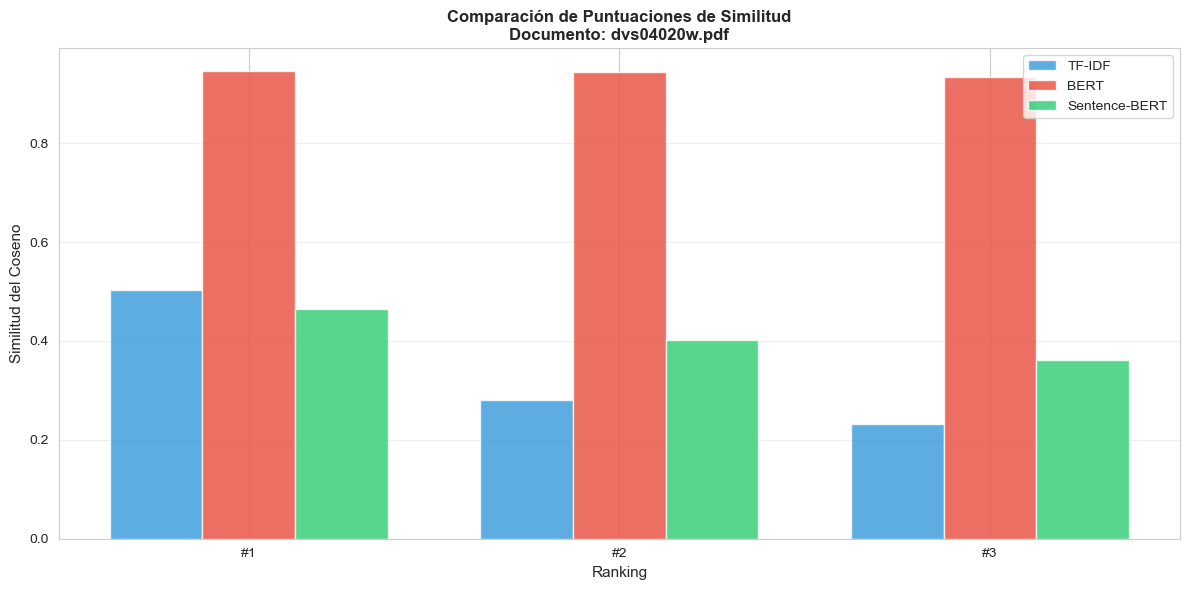

In [11]:
# Visualización de similitudes
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(3)
width = 0.25

tfidf_similar = find_similar_docs(tfidf_matrix, query_idx, top_k=3)
bert_similar = find_similar_docs(bert_embeddings, query_idx, top_k=3)
sbert_similar = find_similar_docs(sbert_embeddings, query_idx, top_k=3)

tfidf_scores = [s[1] for s in tfidf_similar]
bert_scores = [s[1] for s in bert_similar]
sbert_scores = [s[1] for s in sbert_similar]

ax.bar(x - width, tfidf_scores, width, label='TF-IDF', color='#3498db', alpha=0.8)
ax.bar(x, bert_scores, width, label='BERT', color='#e74c3c', alpha=0.8)
ax.bar(x + width, sbert_scores, width, label='Sentence-BERT', color='#2ecc71', alpha=0.8)

ax.set_xlabel('Ranking', fontsize=11)
ax.set_ylabel('Similitud del Coseno', fontsize=11)
ax.set_title(f'Comparación de Puntuaciones de Similitud\nDocumento: {query_doc}', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['#1', '#2', '#3'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Conclusión: Sentence-BERT produce similitudes más consistentes para recuperación semántica

---
## 5. Estructura de Datos y Reutilización

### 5.1 Organización de Archivos

Los datos procesados se han estructurado de la siguiente forma

```
data/
├── raw/                          # PDFs originales
├── processed/
│   ├── processed_documents.pkl   # DataFrame con todos los datos procesados
│   └── statistics.json           # Estadísticas del corpus
├── embeddings/
│   ├── bert_embeddings.npy       # Embeddings BERT (768-d)
│   ├── sbert_embeddings.npy      # Embeddings Sentence-BERT (384-d)
│   └── embedding_stats.json      # Estadísticas de embeddings
├── visualizations/
│   ├── bow_matrix.npy            # Matriz Bag of Words
│   └── tfidf_matrix.npy          # Matriz TF-IDF
└── vocabularies/
    └── vocabularies.json         # Vocabularios BoW y TF-IDF

models/
├── word2vec.model                # Modelo Word2Vec entrenado
├── fasttext.model                # Modelo FastText entrenado
└── oov_analysis.json             # Análisis OOV
```

### 5.2 Formato del DataFrame Principal



Dimensiones: 46 documentos × 9 columnas

Columnas disponibles:
   * filename             → Nombre del archivo PDF
   * raw_text             → Texto original extraído
   * clean_text           → Texto limpio y normalizado
   * tokens               → Lista de tokens
   * lemmas               → Lista de lemas
   * sentences            → Lista de oraciones
   * pos_tags             → Etiquetas Part-of-Speech
   * num_tokens           → Número de tokens
   * num_sentences        → Número de oraciones

---
## 6. Resumen y Conclusiones

### 6.1 Trabajo Realizado

**Preprocesamiento completo:**
- Extracción, limpieza, tokenización y lemmatización
- Estadísticas detalladas del corpus

**Representaciones tradicionales:**
- Bag of Words y TF-IDF implementados
- Análisis de términos más relevantes

**Embeddings no contextuales:**
- Word2Vec y FastText entrenados custom
- GloVe pre-entrenado integrado
- Análisis exhaustivo de palabras OOV

**Embeddings contextuales:**
- BERT y Sentence-BERT aplicados
- Comparación de capacidades de similitud semántica


### 6.2 Resultados Clave

**Cobertura de vocabulario:**
- FastText: mejor manejo de OOV por n-gramas
- GloVe: mayor cobertura inicial pre-entrenada
- Word2Vec custom: específico del dominio

**Similitud semántica:**
- TF-IDF: efectivo para términos compartidos
- BERT: captura contexto pero más costoso
- Sentence-BERT: **óptimo** para similitud de documentos

Para el chatbot, se usará **Sentence-BERT** como representación principal por su balance entre calidad semántica y eficiencia computacional.

